# Proteomic stable isotope probing reveals taxonomically distinct patterns in amino acid assimilation by coastal marine bacterioplankton
## Samuel J. Bryson, et. al.
Data analysis presented in ipython notebook format
- Database sequence and annotation files are located in the SequenceDatabase folder
- Peptide and protein identifications from Sipros PSM searches are in the PeptideProteinData folder

In [1]:
import io
import sys
import numpy as np
import random
import scipy.stats as stats
import scipy.spatial.distance
import scipy.cluster.hierarchy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import matplotlib.patches as mpatches

In [2]:
%matplotlib inline 

## Load Sequence Database
- Fasta file
- Taxonomy annotation file
- bactNOG functional annotation file

In [3]:
class SequenceDatabase():
    
    def __init__(self, name):
        self.name = name
        self.sequence_data = {'faa':{},'fnt':{},'aa_length':{},'taxonomy':{},'bactNOG':{},'KO':{},'go':{},'seed':{}}
        self.taxa_ranks = ['domain','phylum','class','order','family','genus','species']
        self.taxa_index = {'domain':0, 'phylum':1, 'class':2, 'order':3, 'family':4, 'genus':5, 'species':6}
        self.bactNOG_categories = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N',
                                   'O','P','Q','R','S','T','U','V','W','X','Y','Z','na']
        self.bactNOG_index = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,
                              'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,'Z':25,'na':26,'u':26}
        self.bactNOG_category_descriptions = {
                                    'A':'RNA processing and modification',
                                    'B':'Chromatin Structure and dynamics',
                                    'C':'Energy production and conversion',
                                    'D':'Cell cycle control and mitosis',
                                    'E':'Amino acid transport and metabolism',
                                    'F':'Nucleotide transport and metabolism',
                                    'G':'Carbohydrate transport and metabolism',
                                    'H':'Coenzyme transport and metabolism',
                                    'I':'Lipid transport and metabolism',
                                    'J':'Translation, ribosomal structure and biogenesis',
                                    'K':'Transcription',
                                    'L':'Replication, recombination and repair',
                                    'M':'Cell wall/membrane/envelope biogenesis',
                                    'N':'Cell Motility',
                                    'O':'Posttranslational modification, protein turnover, chaperones',
                                    'P':'Inorganic ion transport and metabolism',
                                    'Q':'Secondary metabolites biosynthesis, transport and catabolism',
                                    'R':'General function prediction only',
                                    'S':'Function unknown',
                                    'T':'Signal transduction mechanisms',
                                    'U':'Intracellular trafficking, secretion, and vesicular transport',
                                    'V':'Defense mechanisms',
                                    'W':'Extracellular structures',
                                    'X':'Unclassified',
                                    'Y':'Nuclear structure',
                                    'Z':'Cytoskeleton',
                                    'na':'not assigned'}
        
    def load_faa (self, fasta_file):
        print("loading fasta file: " + fasta_file)
        inF = io.open(fasta_file)
        seq = ""
        seq_id = ""
        for line in inF:
            line = line.strip()
            if line[0] == ">":
                if seq:
                    seq_length = len(seq)
                    self.sequence_data['aa_length'][seq_id] = seq_length
                    self.sequence_data['faa'][seq_id] = seq
                    self.sequence_data['taxonomy'][seq_id] = ('na','na','na','na','na','na','na')
                    self.sequence_data['bactNOG'][seq_id] = ('na','na','na')
                    #self.sequence_data['<><><>'][seq_id] = """"
                    seq = ""
                seq_id = line[1:]
            else:
                seq += line
        if seq:
            seq_length = len(seq)
            self.sequence_data['aa_length'][seq_id] = seq_length
            self.sequence_data['faa'][seq_id] = seq
            self.sequence_data['taxonomy'][seq_id] = ('na','na','na','na','na','na','na')
            self.sequence_data['bactNOG'][seq_id] = ('na','na','na')
            #self.sequence_data['<><><>'][seq_id] = """"
            seq = ""
            seq_id = ""
        inF.close()
        print(" - total sequences: " + str(len(self.sequence_data['faa'])))
        
    def load_taxonomy (self, taxonomy_file):
        print("loading taxonomy annotation file: " + taxonomy_file)
        annotated_count = 0
        inF = io.open(taxonomy_file)                                                            
        for line in inF:
            listLine = line.strip().split("\t")
            if listLine[0] != "ProteinID":
                seq_id = listLine[0]
                dom = listLine[1]
                phy = listLine[2]
                cla = listLine[3]
                odr = listLine[4]
                fam = listLine[5]
                gen = listLine[6]
                spe = listLine[7]
                self.sequence_data['taxonomy'][seq_id] = (dom,phy,cla,odr,fam,gen,spe)
                annotated_count += 1
        inF.close()
        print(" - annotated: "+str(annotated_count))
        print(" - unannotated: "+str(len(self.sequence_data['faa']) - annotated_count))
        
    def load_bactNOG (self, bactNOG_file):
        print("loading bactNOG annotation file: " + bactNOG_file)
        annotated_count = 0
        inF = io.open(bactNOG_file)                                                              
        for line in inF:
            listLine = line.strip().split("\t")
            if listLine[0] != "ProteinID":
                seq_id = listLine[0]
                nog = listLine[1]
                cat = listLine[2]
                des = listLine[3]
                self.sequence_data['bactNOG'][seq_id] = (nog,cat,des)
                annotated_count += 1
        inF.close()
        print(" - annotated: "+str(annotated_count))
        print(" - unannotated: "+str(len(self.sequence_data['faa']) - annotated_count))

    def get_taxonomy (self, seq_id):
        (dom,phy,cla,odr,fam,gen,spe) = self.sequence_data['taxonomy'][seq_id]
        return(dom,phy,cla,odr,fam,gen,spe)

    def get_bactNOG (self, seq_id):
        (nog,cat,des) = self.sequence_data['bactNOG'][seq_id]
        return(nog,cat,des)
    
    def get_bactNOG_category_description (self, cat):
        return(self.bactNOG_category_descriptions[cat])
    
    def print_bactNOG_category_descriptions (self):
        for cat in self.bactNOG_categories:
            print(cat+" : "+self.bactNOG_category_descriptions[cat])
            
    def get_taxa_list (self, output_rank, parent_rank, name):
        taxa_list = []
        for seq_id in self.sequence_data['taxonomy']:
            taxonomy = self.sequence_data['taxonomy'][seq_id]   # (dom,phy,cla,odr,fam,gen,spe)
            taxonomy = list(taxonomy)
            index = self.taxa_index[parent_rank]
            cut_off = self.taxa_index[output_rank] + 1
            taxa_name = taxonomy[index]
            if taxa_name == name:
                full_name = "|".join(taxonomy[:cut_off])
                if full_name not in taxa_list:
                    taxa_list.append(full_name)
        taxa_list.sort()
        print(output_rank+" in "+parent_rank+": "+name)
        for taxa in taxa_list:
            print("\t"+taxa)
        return(taxa_list)

In [4]:
db = SequenceDatabase("db")
db.load_faa("./SequenceDatabase/Database.fasta")
db.load_taxonomy("./SequenceDatabase/DatabaseTaxonomyAnnotations.txt")
db.load_bactNOG("./SequenceDatabase/DatabaseCOGAnnotations.txt")

loading fasta file: ./SequenceDatabase/Database.fasta
 - total sequences: 38916
loading taxonomy annotation file: ./SequenceDatabase/DatabaseTaxonomyAnnotations.txt
 - annotated: 38235
 - unannotated: 681
loading bactNOG annotation file: ./SequenceDatabase/DatabaseCOGAnnotations.txt
 - annotated: 38450
 - unannotated: 466


## Load Sample MS/MS Data
- pep.txt file
- pro.txt file
- some sample metadata

In [5]:
class Sample():
    
    def __init__(self, sample_name, sample_treatment, sample_timepoint, sample_location, sample_database, pro_txt, pep_txt, label_start = 3):
        self.name = sample_name
        self.treatment = sample_treatment
        self.timepoint = sample_timepoint
        self.location = sample_location
        self.sample_database = sample_database
        self.pro_txt = pro_txt
        self.pep_txt = pep_txt
        ## sample proteins ##
        self.proteins = {}  # protein_ID => taxonomy => (dom,phy,cla,odr,fam,gen,spe)
                            #               bactNOG_annotation => (nog, cat, des)
                            #               peptides => ['ASDFGHJK',......]
                            #               enrichments => [0.0]*101
                            #               spectra => [unique_count,shared_count]
        self.protein_id_lookup_dict = {}
        ## sample summary ##
        self.summary = {}   # taxonomic_rank => name(dom,phy,cla,odr,fam,gen,spe) =>    enrichments = [0.0]*101
                            #                                                           protein_count
                            #                                                           nog_category    =>  enrichments= [0.0]*101
                            #                                                                           =>  protein_count
        ## sample stats ##
        self.protein_count = 0
        self.unique_protein_count = 0
        self.peptide_count = 0
        self.spectra_count = 0
        self.unique_spectra_count = 0
        self.normalization_factor = 1
        ## other useful variables ##
        self.taxa_ranks = ['domain','phylum','class','order','family','genus','species']
        self.taxa_index = {'domain':0, 'phylum':1, 'class':2, 'order':3, 'family':4, 'genus':5, 'species':6}
        self.taxa_counts = {}
        self.bactNOG_categories = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','na','u']
        self.bactNOG_index = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,
                              'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,'Z':25,'na':26,'u':26}
        self.bactNOG_counts = {}
        self.enrichment_counts = [0.0]*101
        self.label_start = label_start
        ## sample initialization methods ##
        self.print_metadata()
        self.load_proteins()
        self.load_peptides()
        self.build_summary()
    
    def print_metadata (self):
        print("\nSample:" +
              "\n\tname: "+self.name+"\n\tlocation: "+self.location+
              "\n\ttreatment: "+self.treatment+"\n\ttime-point: "+str(self.timepoint))
    
    def load_proteins (self):
        print("loading pro.txt file: " + self.pro_txt)
        inFile = io.open(self.pro_txt)
        for line in inFile:
            if line[0] != '#':
                line_list = line.strip().split("\t")
                if line_list[8] == 'T':
                    self.protein_count += 1
                    protein_string = line_list[0]
                    protein_list = self.pro_to_list(protein_string)
                    taxonomy_annotation = self.annotate_taxonomy(protein_list)
                    bactNOG_annotation = self.annotate_bactNOG(protein_list)
                    if len(protein_list) == 1:
                        self.unique_protein_count += 1
                    self.proteins[protein_string] = {}
                    self.proteins[protein_string]['taxonomy'] = taxonomy_annotation  # ['D','P','C','O','F','G','S'] 
                    self.proteins[protein_string]['bactNOG'] = bactNOG_annotation   # [bactNOG_number, bactNOG_category, description]
                    self.proteins[protein_string]['peptides'] = []
                    self.proteins[protein_string]['enrichments'] = [0.0]*101
                    self.proteins[protein_string]['peptide_counts'] = [int(line_list[1]),int(line_list[2])] # [unique, total]
                    self.proteins[protein_string]['spectra_counts'] = [int(line_list[3]),int(line_list[4])] # [unique, total]
                    for prot in protein_list:
                        self.protein_id_lookup_dict[prot] = protein_string
        inFile.close()
        print("\ttotal Protein IDs: " + str(self.protein_count))
        
    def load_peptides (self):
        print("loading pep.txt file: " + self.pep_txt)
        inFile = io.open(self.pep_txt)
        for line in inFile:
            if line[0] != '#':
                line_list = line.strip().split("\t")
                if line_list[5] == 'T':
                    peptide = line_list[2][1:-1]
                    self.peptide_count += 1
                    protein_string = line_list[3]
                    protein_list = self.pro_to_list(protein_string)
                    pro_list = []
                    for pro in protein_list:    # not every protein with peptide ID is a protein ID passing 1 unique + 1 other peptide
                        if pro in self.protein_id_lookup_dict:
                            pro_list.append(self.protein_id_lookup_dict[pro])
                    pro_set = set(pro_list)
                    pro_count = len(pro_set)
                    enrichment_string = line_list[10]
                    enrichment_list = self.parse_enrichments(enrichment_string)
                    if len(pro_set) == 1:
                            self.unique_spectra_count += len(enrichment_list)
                    if pro_count > 0:
                        val = 1.0/pro_count
                        self.spectra_count += len(enrichment_list)
                        for p in pro_set:
                            for enr in enrichment_list:
                                self.proteins[p]['enrichments'][enr] += val
                            self.proteins[p]['peptides'].append(peptide)
        inFile.close()
        print("\ttotal Spectra: " + str(self.spectra_count))
        print("\ttotal Peptide IDs: " + str(self.peptide_count))
        
    def annotate_taxonomy (self,protein_list):
        taxonomy_annotation = ['u','u','u','u','u','u','u']
        dom_list = []
        phy_list = []
        cla_list = []
        odr_list = []
        fam_list = []
        gen_list = []
        spe_list = []
        for protein_id in protein_list:
            (dom,phy,cla,odr,fam,gen,spe) = self.sample_database.get_taxonomy(protein_id)
            dom_list.append(dom)
            phy_list.append(phy)
            cla_list.append(cla)
            odr_list.append(odr)
            fam_list.append(fam)
            gen_list.append(gen)
            spe_list.append(spe);
        taxa = [dom_list,phy_list,cla_list,odr_list,fam_list,gen_list,spe_list]
        for x in range(len(taxa)):
            y = taxa[x];
            z = set(y);
            if len(z) == 1:
                taxonomy_annotation[x] = y[0]
            else:
                taxonomy_annotation[x] = 'u'
        return(taxonomy_annotation)

    def annotate_bactNOG (self, protein_list):
        bactNOG_annotation = ['u','u','u']
        bactNOG_numbers = []
        bactNOG_categories = []
        bactNOG_descriptions = []
        for protein_id in protein_list:
            (nog,cat,des) = self.sample_database.get_bactNOG(protein_id)
            bactNOG_numbers.append(nog)
            bactNOG_categories.append(cat)
            bactNOG_descriptions.append(des)
        bactNOG_annotation_lists = [bactNOG_numbers,bactNOG_categories,bactNOG_descriptions]
        for x in range(len(bactNOG_annotation_lists)):
            y = bactNOG_annotation_lists[x]
            z = set(y)
            if len(z) == 1:
                bactNOG_annotation[x] = y[0]
            else:
                bactNOG_annotation[x] = 'u'
        return(bactNOG_annotation)

    def build_summary(self):
        for r in self.taxa_ranks:
            self.summary[r] = {}
        for protein_string in self.proteins:
            (dom,phy,cla,odr,fam,gen,spe) = self.proteins[protein_string]['taxonomy']
            D = dom
            P = dom+"|"+phy
            C = dom+"|"+phy+"|"+cla
            O = dom+"|"+phy+"|"+cla+"|"+odr
            F = dom+"|"+phy+"|"+cla+"|"+odr+"|"+fam
            G = dom+"|"+phy+"|"+cla+"|"+odr+"|"+fam+"|"+gen
            S = dom+"|"+phy+"|"+cla+"|"+odr+"|"+fam+"|"+gen+"|"+spe
            phylogeny = [D,P,C,O,F,G,S]
            enrichments = self.proteins[protein_string]['enrichments']
            [nog,cat,des] = self.proteins[protein_string]['bactNOG']
            parsed_cat = self.parse_cat(cat)
            for rank in self.taxa_index:
                name = phylogeny[self.taxa_index[rank]]
                if name not in self.summary[rank]:
                    self.summary[rank][name] = {}
                    self.summary[rank][name]['enrichments'] = [0.0]*101
                    self.summary[rank][name]['protein_count'] = 0.0
                    self.summary[rank][name]['bactNOG'] = {}
                    for bnc in self.bactNOG_categories:
                        self.summary[rank][name]['bactNOG'][bnc] = {}
                        self.summary[rank][name]['bactNOG'][bnc]['enrichments'] = [0.0]*101
                        self.summary[rank][name]['bactNOG'][bnc]['protein_count'] = 0.0
                self.summary[rank][name]['enrichments'] = [x + y for x,y in zip(self.summary[rank][name]['enrichments'],enrichments)]
                self.summary[rank][name]['protein_count'] += 1
                for c in parsed_cat:
                    self.summary[rank][name]['bactNOG'][c]['enrichments'] = [x + y/len(parsed_cat) for x,y in zip(self.summary[rank][name]['bactNOG'][c]['enrichments'],enrichments)]
                    self.summary[rank][name]['bactNOG'][c]['protein_count'] += 1.0/len(parsed_cat)
        for rank in self.summary:
            casf_sum = 0.0   # sum of carbon assimilation factor => sum( pbsc(i) * plsc(i) * enrv(i) for i in rank)
            for name in self.summary[rank]:
                enrichments = self.summary[rank][name]['enrichments']
                pbsc = sum(enrichments)/self.spectra_count
                plsc, enrv, enrf = self.calc_enrichment_stats(enrichments, self.label_start)
                self.summary[rank][name]['pbsc'] = pbsc
                self.summary[rank][name]['plsc'] = plsc
                self.summary[rank][name]['enrv'] = enrv
                self.summary[rank][name]['enrf'] = enrf
                casf_sum += (pbsc*plsc*enrv)
            for name in self.summary[rank]:
                if casf_sum > 0.0:
                    casf = self.summary[rank][name]['pbsc']*self.summary[rank][name]['plsc']*self.summary[rank][name]['enrv']/casf_sum
                else:
                    casf = 0.0
                self.summary[rank][name]['casf'] = casf
                
    def pro_to_list (self, protein_string): #input pro IDs {idA,idB,...,idN} -> return [idA,...idN]
        protein_list = []
        if protein_string[0] == "{":    
            protein_string = protein_string[1:-1]
        protein_list = protein_string.split(',')
        protein_list = [p for p in protein_list if 'Rev' not in p]
        return(protein_list)

    def parse_enrichments (self, enrichment_string): #input string "{C13_1Pct,C13_1Pct}" -> output int list [1,1]
        enrichment_list = []
        if "Null" in enrichment_string:
            enrichment_list = [1]*enrichment_string.count("Null")
        else:
            enrichment_string = enrichment_string[1:-1]
            enrichment_list = enrichment_string.replace('C13_','').replace('Pct','').split(',')
            enrichment_list = [int(e) for e in enrichment_list]
        return(enrichment_list)
    
    def parse_cat (self,cat):
        if 'na' in cat:
            parsed_cat = ['na']
        else:
            parsed_cat = [c for c in cat]
        return(parsed_cat)
    
    def calc_enrichment_stats (self, enrichments, start_index):
        spec_count = sum(enrichments)
        lsc = sum(enrichments[start_index:])
        plsc = lsc/spec_count
        enr_vals = [x*y/100 for x,y in zip(enrichments, range(len(enrichments)))]
        enr_sum = sum(enr_vals[start_index:])
        if lsc > 0.0:
            enrv = enr_sum/lsc
        else:  
            enrv = 0.0
        enrf = plsc * enrv
        return(plsc, enrv, enrf)
    
    def sample_taxonomy_counts (self, rank, data_type = 'protein', min_count = 0):
        self.taxa_counts = {}
        taxa_list = []
        for name in self.summary[rank]:
            if data_type == 'protein':
                count = self.summary[rank][name]['protein_count']
            if data_type == 'spectra':
                count = sum(self.summary[rank][name]['enrichments'])
            self.taxa_counts[name] = [count]
            
    def sample_bactNOG_counts (self, data_type = 'protein'):
        for cat in self.bactNOG_categories:
            self.bactNOG_counts[cat] = [0.0]
        for protein_string in self.proteins:
            [nog,cat,des] = self.proteins[protein_string]['bactNOG']
            parsed_cat = self.parse_cat(cat)
            if data_type == 'protein':
                count = 1.0/len(parsed_cat)
            if data_type == 'spectra':
                count = sum(self.proteins[protein_string]['enrichments'])/len(parsed_cat)
            for c in parsed_cat:
                self.bactNOG_counts[c][0] += count
                
    def sample_enrichment_counts (self, bin_list = range(1,101,9)):
        self.enrichment_bins = {}
        self.enrichment_hist = {}
        self.enrichment_names = []
        self.enrichment_counts = [0.0]*101
        for protein_string in self.proteins:
            enr = self.proteins[protein_string]['enrichments']
            self.enrichment_counts = [x+y for x,y in zip(self.enrichment_counts,enr)]
        x = 0
        for i in range(len(bin_list)):
            for n in range(x,bin_list[i]+1):
                bin_name = str(x)+"--"+str(bin_list[i])
                self.enrichment_bins[bin_name] = self.enrichment_bins.get(bin_name, 0.0) + self.enrichment_counts[n]
            self.enrichment_names.append(bin_name)
            x = n+1
        self.enrichment_sum = sum(self.enrichment_counts[self.label_start:])
        for bin_name in self.enrichment_bins:
            self.enrichment_hist[bin_name] = [self.enrichment_bins[bin_name]/self.enrichment_sum]
            self.enrichment_bins[bin_name] = [self.enrichment_bins[bin_name]/self.spectra_count]
        self.plsc, self.enrv, self.enrf = self.calc_enrichment_stats(self.enrichment_counts, self.label_start)
        

In [6]:
MB1a = Sample("MB1a", "amino_acids", 1, "MB", db, "./PeptideProteinData/MB1a.pro.txt", "./PeptideProteinData/MB1a.pep.txt", label_start=2)
MB1b = Sample("MB1b", "amino_acids", 1, "MB", db, "./PeptideProteinData/MB1b.pro.txt", "./PeptideProteinData/MB1b.pep.txt", label_start=2)
MB1c = Sample("MB1c", "amino_acids", 1, "MB", db, "./PeptideProteinData/MB1c.pro.txt", "./PeptideProteinData/MB1c.pep.txt", label_start=2)
MB2a = Sample("MB2a", "amino_acids", 2, "MB", db, "./PeptideProteinData/MB2a.pro.txt", "./PeptideProteinData/MB2a.pep.txt", label_start=2)
MB2b = Sample("MB2b", "amino_acids", 2, "MB", db, "./PeptideProteinData/MB2b.pro.txt", "./PeptideProteinData/MB2b.pep.txt", label_start=2)
MB2c = Sample("MB2c", "amino_acids", 2, "MB", db, "./PeptideProteinData/MB2c.pro.txt", "./PeptideProteinData/MB2c.pep.txt", label_start=2)
OR1 = Sample("OR1", "amino_acids", 1, "OR", db, "./PeptideProteinData/OR1.pro.txt", "./PeptideProteinData/OR1.pep.txt", label_start=2)
OR2 = Sample("OR2", "amino_acids", 2, "OR", db, "./PeptideProteinData/OR2.pro.txt", "./PeptideProteinData/OR2.pep.txt", label_start=2)


Sample:
	name: MB1a
	location: MB
	treatment: amino_acids
	time-point: 1
loading pro.txt file: ./PeptideProteinData/MB1a.pro.txt
	total Protein IDs: 3378
loading pep.txt file: ./PeptideProteinData/MB1a.pep.txt
	total Spectra: 22208
	total Peptide IDs: 18631

Sample:
	name: MB1b
	location: MB
	treatment: amino_acids
	time-point: 1
loading pro.txt file: ./PeptideProteinData/MB1b.pro.txt
	total Protein IDs: 3613
loading pep.txt file: ./PeptideProteinData/MB1b.pep.txt
	total Spectra: 22669
	total Peptide IDs: 19800

Sample:
	name: MB1c
	location: MB
	treatment: amino_acids
	time-point: 1
loading pro.txt file: ./PeptideProteinData/MB1c.pro.txt
	total Protein IDs: 3513
loading pep.txt file: ./PeptideProteinData/MB1c.pep.txt
	total Spectra: 25157
	total Peptide IDs: 19668

Sample:
	name: MB2a
	location: MB
	treatment: amino_acids
	time-point: 2
loading pro.txt file: ./PeptideProteinData/MB2a.pro.txt
	total Protein IDs: 2885
loading pep.txt file: ./PeptideProteinData/MB2a.pep.txt
	total Spect

#Compare Samples
- Taxonomic distribution of protein identifications
- Functional distribution of protein identifications
- Distribution of labeled peptide spectral matches (PSM)

###Functions will iterate over a list of sample objects

In [7]:
sample_list = [OR2,OR1,MB2c,MB2b,MB2a,MB1c,MB1b,MB1a]
sample_names = ['OR2','OR1','MB2c','MB2b','MB2a','MB1c','MB1b','MB1a']
rev_sample_names = list(reversed(sample_names))

###For much of the analysis we will only plot the taxonomic orders with relatively more protein identifications 

In [8]:
odr = ['Bacteria|Proteobacteria|Alphaproteobacteria|Rhodobacterales', 
         'Bacteria|Proteobacteria|Gammaproteobacteria|Alteromonadales', 
         'Bacteria|Proteobacteria|Alphaproteobacteria|SAR116', 
         'Bacteria|Proteobacteria|Alphaproteobacteria|SAR11', 
         'Bacteria|Proteobacteria|Betaproteobacteria|Methylophilales', 
         'Bacteria|Cyanobacteria|Oscillatoriophycideae|Chroococcales', 
         'Bacteria|Proteobacteria|Gammaproteobacteria|SAR86', 
         'Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales', 
         'Bacteria|Proteobacteria|Gammaproteobacteria|SAR92', 
         'Bacteria|Proteobacteria|Gammaproteobacteria|OMG', 
         'Bacteria|Proteobacteria|Gammaproteobacteria|Oceanospirillales']
odr.sort()

## Some General Functions for Plots and Data Output
- print-it
- h_stacked_bar_plot
- heatmap
- multi_histograms

In [9]:
def print_it (index, data_dict, row_list, column_list):
        header = (index+"\t"+"\t".join(column_list))
        print(header)
        for row in row_list:
            vals = [str(data_dict[row][column][0]) for column in column_list]
            line = (row+"\t"+"\t".join(vals))
            print(line)

In [10]:
def h_stacked_bar_plot (data_dict, group_list, labels_list, colormap = "Accent",start_index = 0, x_label = "", y_label = "", plot_name = ""):
    #data_dict structure -> key[x axis category] -> key[group name] -> [y value, < y error(optional) >]
    labels_list = labels_list[start_index:]
    label_txt = []
    for lab in labels_list:
        if lab.count('|') > 0 :
            lab = lab.split("|")
            lab = lab[-1]
            label_txt.append(lab)
        else:
            label_txt = labels_list
    fig = plt.figure(figsize=(12,8),dpi=900)
    gs = gridspec.GridSpec(1, 2,width_ratios=[2,1])
    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[0,1])
    #fig, ax = plt.subplots(2,1,figsize=(8,8),dpi=900)
    n = len(group_list)
    m = len(labels_list)
    height = 0.7
    #colors = [plt.get_cmap(colormap)(float(j)/m) for j in range(len(labels_list))]
    for i in range(len(group_list)):
        x = 0.0
        for j in range(len(labels_list)):
            val = data_dict[group_list[i]].get(labels_list[j],[0.0])
            val = val[0]
            pos = i+1
            ax1.barh(pos, val,height = height, left = x, align = 'center', color=plt.get_cmap(colormap)(float(j)/m))
            x += val
        ax1.barh(pos, 1-x, height = height, left = x, align = 'center', color=plt.get_cmap('Greys')(0.5))
    colors = [plt.get_cmap(colormap)(float(j)/m) for j in range(len(labels_list))]
    colors.append(plt.get_cmap('Greys')(0.5))
    label_txt.append("Other")
    ax1.set_xlim(0,1)
    ax1.set_xticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    # Set the y-axis tick labels to be equal to the categories
    ax1.set_ylim(1-height,len(group_list)+height)
    ax1.set_yticks(range(1, len(group_list)+1))
    ax1.set_yticklabels(group_list)
    # Add the axis labels
    ax1.set_ylabel(y_label)
    ax1.set_title(x_label)
    # Add a legend
    ax2.axis('off')
    handles = []
    for l,c in zip(label_txt,colors):
        handles.append(mpatches.Patch(color=c, label=l))
    ax2.legend(handles,label_txt)
    if plot_name:
        plt.savefig(plot_name)
    plt.show()

In [11]:
def heatmap (data_dict, row_list, column_list, colormap = "Blues", plot_name = "", start_index = 0, transform='no'):
    data_array = []
    column_list = column_list[start_index:]
    for row in row_list:
        row_data = []
        for column in column_list:
            row_data.append(data_dict[row][column][0])
        data_array.append(row_data)
    data_array = np.asarray(data_array)
    max_val = np.amax(data_array)
    min_val = np.amin(data_array)
    med_val = np.median(data_array)
    avg_val = np.mean(data_array)
    middle_val = np.amax(data_array) - (np.amax(data_array) - np.amin(data_array))/2.0 
    if transform == 'yes':
        data_array = np.sqrt(data_array)
        middle_val = np.square(np.amax(data_array)/2)
    fig = plt.figure(figsize=(6,9),dpi=900)
    gs = gridspec.GridSpec(2,1,height_ratios=[8,1])
    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[1,0])
    ax1.pcolor(data_array,cmap=plt.get_cmap(colormap),edgecolors='k')
    ax1.set_xticks(np.arange(0,len(column_list))+0.5)
    ax1.set_yticks(np.arange(0,len(row_list))+0.5)
    ax1.xaxis.tick_top()
    ax1.yaxis.tick_right()
    ax1.set_xticklabels(column_list,minor=False,fontsize=8, rotation=45)
    ax1.set_yticklabels(row_list,minor=False,fontsize=8)
    ax1.set_xlim(0,len(column_list))
    ax1.set_ylim(0,len(row_list))
    # standard axis elements
    fig.subplots_adjust(wspace=0)
    fig.subplots_adjust(hspace=0.1)
    #add heatmap legend#
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))
    ax2.imshow(gradient, aspect='auto',cmap=plt.get_cmap(colormap))
    pos = list(ax2.get_position().bounds)
    ax2.get_yaxis().set_visible(False)
    ax2.set_xticks([0,128,256])
    ax2.set_xticklabels([str(min_val),str(middle_val),str(max_val)])
    if plot_name:
        plt.savefig(plot_name)
    plt.show()

In [12]:
def multi_bar_plot (data_dict, row_list, column_list, start_index = 0, error_bars = "no", colormap = "Accent",
             colornum = "", plot_name = "", y_max = ""):
    data_array = {}
    max_val = 0.0
    column_list = column_list[start_index:]
    for row in row_list:
        row_data = []
        error_data = []
        for column in column_list:
            val = data_dict[row][column][0]
            row_data.append(val)
            if val > max_val:
                max_val = val
            if error_bars == 'yes':
                error_data.append(data_dict[row][column][1])
        data_array[row] = [row_data,error_data]
    pos_list = np.arange(1,len(column_list)+1)
    width = 0.75
    fig, ax = plt.subplots(len(row_list), 1, figsize=(6,len(row_list)),dpi=900, sharey=True, sharex=True)
    fig.subplots_adjust(bottom=0) #make room for the legend
    fig.subplots_adjust(hspace=0)
    if y_max:
        y_max = y_max
    else:
        y_max = max_val
    plt.yticks([0,y_max])
    plt.xticks(pos_list,column_list, fontsize=8, rotation=45)
    for i in range(len(row_list)):
        val_err = data_array[row_list[i]]
        vals = val_err[0]
        if error_bars == 'yes':
            errs = val_err[1]
        if colornum:
            colornum = colornum
        else:
            colornum = 1.0/len(row_list)*i
        if error_bars == "yes":
            ax[i].bar(pos_list, vals, width=width, color=plt.get_cmap(colormap)(colornum), align = 'center',
                      yerr = errs, error_kw = dict(ecolor='black', lw=1, capsize=1, capthick=1))
        else:
            ax[i].bar(pos_list, vals, width=width, color=plt.get_cmap(colormap)(colornum), align = 'center')
        ax[i].set_ylim(0, y_max)
        ax[i].set_ylabel(row_list[i], verticalalignment='center', rotation='horizontal', horizontalalignment='right',size=8)
        ax[i].set_yticklabels(['0',str(y_max)])
    if plot_name:
        plt.savefig(plot_name)
    plt.show()

## Taxonomy
First we compare relative numbers of protein identifications for some abundant orders. The plot will show the proportion of protein identifications for each order in each sample. Spectral counts could also be displayed, as well as higher or lower taxonomic ranks.

In [13]:
def compare_taxonomy_counts (sample_list, sample_names, rank, data_type = 'protein', min_count = 0,
                                taxa_to_plot = "", plot='no', print_txt='no', colormap = "Set1", save_plot=""):
        taxa_list = []
        taxa_counts = {}
        for sample in sample_list:
            taxa_counts[sample.name] = {}
            sample.sample_taxonomy_counts(rank=rank, data_type=data_type)
            for taxa in sample.taxa_counts:
                if data_type == 'protein':
                    count = sample.taxa_counts[taxa][0] / sample.protein_count
                    taxa_counts[sample.name][taxa] = [count]
                if data_type == 'spectra':
                    count = sample.taxa_counts[taxa][0] / sample.spectra_count
                    taxa_counts[sample.name][taxa] = [count]
        for sample_name in taxa_counts:
            for taxa in taxa_counts[sample_name]:
                count = taxa_counts[sample_name][taxa][0]
                if count >= min_count:
                    taxa_list.append(taxa)
            taxa_set = set(taxa_list)
            taxa_list = list(taxa_set)
            taxa_list.sort()
        if taxa_to_plot:
            taxa_list = taxa_to_plot
        else:
            taxa_list = self.taxa_list
        if print_txt == "yes":
            for sample in sample_list:
                for taxa in taxa_list:
                    if data_type == 'protein':
                        val = taxa_counts[sample.name].get(taxa,[0])
                        val[0] = val[0]*sample.protein_count
                        taxa_counts[sample.name][taxa]= val
                    if data_type == 'spectra':
                        val = taxa_counts[sample.name].get(taxa,[0])
                        val[0] = val[0]*sample.spectra_count
                        taxa_counts[sample.name][taxa]= val
            print_it (rank, taxa_counts, sample_names, taxa_list) # data_dict, rows, columns
        if plot == "yes":
            figure = h_stacked_bar_plot(taxa_counts, sample_names, taxa_list, colormap=colormap, start_index = 0,
                                      x_label = "relative abundance", y_label = "samples", plot_name = save_plot)

###Stacked Bar Chart

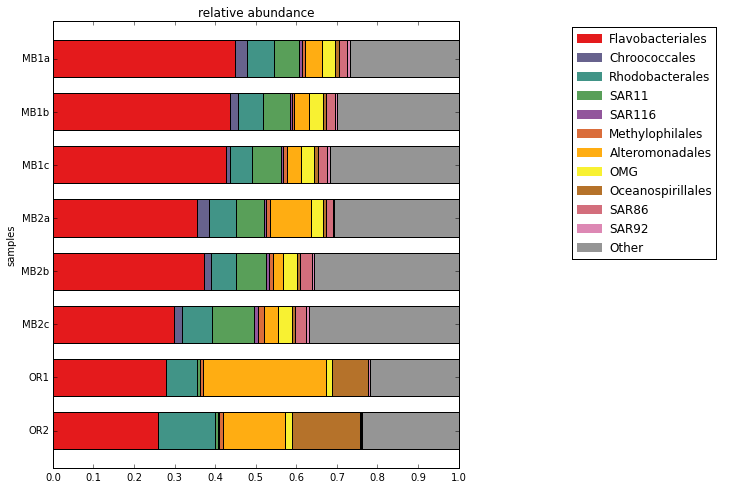

In [14]:
compare_taxonomy_counts(sample_list, sample_names, 'order', data_type = 'protein', min_count = 0.0001,
                           taxa_to_plot = odr, plot='yes', colormap="Set1", save_plot="")

## Table of protein identification counts

In [15]:
compare_taxonomy_counts(sample_list, rev_sample_names, 'order', data_type = 'protein', min_count = 0.0001,
                           taxa_to_plot = odr, plot='no', print_txt='yes')

order	Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales	Bacteria|Cyanobacteria|Oscillatoriophycideae|Chroococcales	Bacteria|Proteobacteria|Alphaproteobacteria|Rhodobacterales	Bacteria|Proteobacteria|Alphaproteobacteria|SAR11	Bacteria|Proteobacteria|Alphaproteobacteria|SAR116	Bacteria|Proteobacteria|Betaproteobacteria|Methylophilales	Bacteria|Proteobacteria|Gammaproteobacteria|Alteromonadales	Bacteria|Proteobacteria|Gammaproteobacteria|OMG	Bacteria|Proteobacteria|Gammaproteobacteria|Oceanospirillales	Bacteria|Proteobacteria|Gammaproteobacteria|SAR86	Bacteria|Proteobacteria|Gammaproteobacteria|SAR92
MB1a	1519.0	95.0	227.0	206.0	25.0	24.0	147.0	107.0	28.0	67.0	25.0
MB1b	1576.0	72.0	227.0	234.0	21.0	21.0	127.0	128.0	26.0	80.0	21.0
MB1c	1501.0	32.0	190.0	253.0	20.0	29.0	123.0	112.0	33.0	82.0	22.0
MB2a	1023.0	87.0	194.0	199.0	15.0	25.0	290.0	88.0	21.0	47.0	10.0
MB2b	1032.0	46.0	173.0	206.0	17.0	32.0	68.0	91.0	24.0	84.0	14.0
MB2c	856.0	52.0	213.0	296.0	32.0	41.0	96.0	98.0	25.0	78.0	17.0


## bactNOGs
Next we compare relative numbers of protein identifications for some COG functional categories. The heatmap will show the proportion of protein identifications for each category in each sample. Proportions of spectral counts could also be used.

## We use a reduced list of categories for the heatmap

In [14]:
bactNOG_category_list = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','na','u']
reduced_list = ['C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V']

In [15]:
def experiment_bacNOG_counts (sample_list, sample_names, cat_list, data_type = 'protein', plot = 'no',
                            save_plot = '', print_txt = 'no', colormap = 'Blues', transform = 'no'):
    bactNOG_counts = {}
    for sample in sample_list:
        bactNOG_counts[sample.name] = {}
        sample.sample_bactNOG_counts(data_type=data_type)
        for cat in cat_list:
            if data_type == 'protein':
                bactNOG_counts[sample.name][cat] = [sample.bactNOG_counts[cat][0]/sample.protein_count]
            if data_type == 'spectra':
                bactNOG_counts[sample.name][cat] = [sample.bactNOG_counts[cat][0]/sample.spectra_count]
    if print_txt == 'yes':
        for sample in sample_list:
            for cat in cat_list:
                if data_type == 'protein':
                    val = bactNOG_counts[sample.name].get(cat,[0])
                    val[0] = val[0]*sample.protein_count
                    bactNOG_counts[sample.name][cat]= val
                if data_type == 'spectra':
                    val = bactNOG_counts[sample.name].get(cat,[0])
                    val[0] = val[0]*sample.spectra_count
                    bactNOG_counts[sample.name][cat]= val
        print_it("sample", bactNOG_counts, sample_names, cat_list)
    if plot == "yes":
        figure = heatmap(bactNOG_counts, sample_names, cat_list, plot_name=save_plot, colormap=colormap, transform=transform)

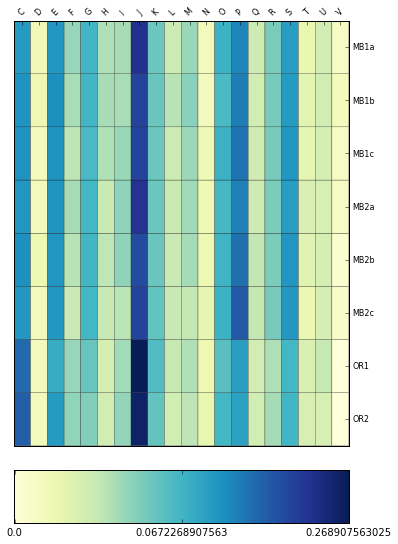

In [18]:
experiment_bacNOG_counts(sample_list, sample_names, data_type = 'protein', cat_list = reduced_list, plot = 'yes',
                         transform = 'yes', colormap = 'YlGnBu', save_plot = '')

###Table of total protein identifications in COG categoroes for each sample

In [16]:
experiment_bacNOG_counts(sample_list, rev_sample_names, data_type='protein', cat_list=bactNOG_category_list, print_txt='yes')

sample	A	B	C	D	E	F	G	H	I	J	K	L	M	N	O	P	Q	R	S	T	U	V	W	X	Y	Z	na	u
MB1a	0.0	0.0	319.0	10.0	329.0	101.0	226.5	78.5	85.5	718.5	158.0	50.0	100.0	8.0	241.0	382.0	48.5	135.0	311.0	17.5	42.5	5.0	0.5	0.0	0.0	0.0	8.0	3.0
MB1b	0.0	0.0	369.0	14.0	383.0	89.5	241.0	90.5	88.5	664.0	171.0	75.0	124.5	7.0	224.0	443.5	45.0	148.0	340.0	25.5	47.5	8.0	0.5	0.0	0.0	0.0	11.0	3.0
MB1c	0.0	0.0	361.0	8.0	356.5	67.0	221.0	79.0	104.0	646.0	165.0	52.0	100.0	12.0	254.0	459.0	49.0	142.0	347.0	22.5	41.5	5.0	0.5	0.0	0.0	0.0	11.0	10.0
MB2a	0.0	0.0	285.0	8.0	291.5	73.0	188.5	45.0	94.5	595.0	134.0	45.0	78.5	10.0	187.0	346.0	42.5	112.0	269.0	29.5	31.0	4.0	0.0	0.0	0.0	0.0	8.0	8.0
MB2b	0.0	0.0	294.0	11.0	273.5	58.5	184.0	51.5	91.0	485.0	132.0	45.0	72.0	11.0	191.0	371.0	51.0	109.0	274.0	21.5	31.5	1.0	0.5	0.0	0.0	0.0	8.0	5.0
MB2c	0.0	0.0	280.0	7.0	279.5	46.5	189.0	47.5	58.0	525.0	144.0	48.0	50.0	17.0	202.0	453.0	50.0	117.0	280.0	13.5	34.0	2.0	1.0	0.0	0.0	0.0	11.0	5.0
OR1	0.0	0.0	166.0	3.0	91.5	36.0	57.0	13.5	32.0	320.0	70.0	20.0

## Labeled PSM Histogram
Finally we examine the distribution of labeled spectra in each sample. We set bin widths for percent 13C enrichment of peptide spectral matches (PSM) for the histogram. The plot can either present total spectra in each bin as a total of all spectra aquired in a sample ('bsc' option) or as a percentage of only the labeled spectra ('lsc' option, used here).

In [20]:
def experiment_enrichment_counts (sample_list, sample_names, bin_list = range(1,101,9),
                                start_index = 1, plot = 'no', save_plot = '', print_txt = 'no',
                                  y_max = "", colormap = "Accent", colornum = 0.1, proportion = 'bsc'):
    ## range(1,101,9) = [1, 10, 19, 28, 37, 46, 55, 64, 73, 82, 91, 100]
    ## range(2,101,7) = [2, 9, 16, 23, 30, 37, 44, 51, 58, 65, 72, 79, 86, 93, 100]
    enrichment_bins = {}
    bin_names = []
    x = 0
    for i in range(len(bin_list)):
        for n in range(x,bin_list[i]+1):
            bin_name = str(x)+"--"+str(bin_list[i])
        bin_names.append(bin_name)
        x = n+1
    for sample in sample_list:
        enrichment_bins[sample.name] = {}
        sample.sample_enrichment_counts(bin_list = bin_list)
        for bin_name in bin_names:
            if proportion == 'bsc':
                enrichment_bins[sample.name][bin_name] = [sample.enrichment_bins[bin_name][0]]
            if proportion == 'lsc':
                enrichment_bins[sample.name][bin_name] = [sample.enrichment_hist[bin_name][0]]
    #if print_txt == 'yes':
    if plot == "yes":
        figure = multi_bar_plot(enrichment_bins, sample_names, bin_names, start_index = start_index, error_bars = "no",
                                         colormap=colormap, colornum=colornum, plot_name=save_plot, y_max=y_max)

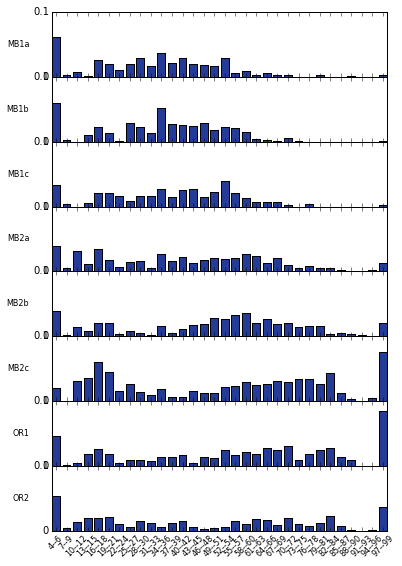

In [21]:
experiment_enrichment_counts(sample_list, rev_sample_names, bin_list = range(3,101,3), start_index = 1, plot = 'yes',
                                    save_plot = '', print_txt = 'no', y_max = 0.1, colormap = 'YlGnBu', colornum=0.85, proportion='lsc')

### Table summarizing the histograms above
- plsc = 'label frequency': the relative frequency of labeled PSM in each sample
- enrv = 'average enrichment': the average percent 13C enrichment of labeled PSM in each sample 

In [22]:
for sample in sample_list:
    sample.sample_enrichment_counts(bin_list = range(2,101,3))
    print(sample.name+"\ntotal spectra: "+str(sample.spectra_count)+"\nlabeled spectra: "+str(sample.enrichment_sum))
    print("sample plsc: "+str(sample.plsc)+"\nsample enrv: "+str(sample.enrv))

OR2
total spectra: 6374
labeled spectra: 659.0
sample plsc: 0.103388766865
sample enrv: 0.207587253414
OR1
total spectra: 6554
labeled spectra: 604.0
sample plsc: 0.0921574610925
sample enrv: 0.330397350993
MB2c
total spectra: 17510
labeled spectra: 1002.0
sample plsc: 0.0572244431753
sample enrv: 0.399331337325
MB2b
total spectra: 17928
labeled spectra: 808.0
sample plsc: 0.0450691655511
sample enrv: 0.247735148515
MB2a
total spectra: 15959
labeled spectra: 630.0
sample plsc: 0.039476157654
sample enrv: 0.201714285714
MB1c
total spectra: 25157
labeled spectra: 539.0
sample plsc: 0.0214254481854
sample enrv: 0.155695732839
MB1b
total spectra: 22669
labeled spectra: 617.0
sample plsc: 0.0272177864043
sample enrv: 0.160129659643
MB1a
total spectra: 22208
labeled spectra: 540.0
sample plsc: 0.0243155619597
sample enrv: 0.149611111111


## Compare Taxa
- Protein identifications and spectral counts in each sample
- 'label frequency' in each sample ("plsc")
- 'average enrichment' in each sample ("enrv")

In [23]:
def get_taxa_data (sample_list, samples_names, rank, taxa_list, d_type):
    names = "\t".join(samples_names)
    print(rank+"\t"+names)
    for name in taxa_list:
        data = []
        for sample in sample_list:
            if name in sample.summary[rank]:
                if d_type == 'spec':
                    data.append(sum(sample.summary[rank][name]['enrichments']))
                else:
                    prot = sample.summary[rank][name]['protein_count']
                    pbs = sample.summary[rank][name]['pbsc']
                    pls = sample.summary[rank][name]['plsc']
                    enr = sample.summary[rank][name]['enrv']
                    caf = sample.summary[rank][name]['casf']
                    data.append(sample.summary[rank][name][d_type])
            else:
                data.append(0.0)
        line = "\t".join([str(x) for x in data])
        print(name+"\t"+line)
    return()

### Protein identifications

In [25]:
get_taxa_data (sample_list, sample_names, 'order', odr, 'protein_count')

order	OR2	OR1	MB2c	MB2b	MB2a	MB1c	MB1b	MB1a
Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales	296.0	331.0	856.0	1032.0	1023.0	1501.0	1576.0	1519.0
Bacteria|Cyanobacteria|Oscillatoriophycideae|Chroococcales	0.0	1.0	52.0	46.0	87.0	32.0	72.0	95.0
Bacteria|Proteobacteria|Alphaproteobacteria|Rhodobacterales	161.0	91.0	213.0	173.0	194.0	190.0	227.0	227.0
Bacteria|Proteobacteria|Alphaproteobacteria|SAR11	9.0	8.0	296.0	206.0	199.0	253.0	234.0	206.0
Bacteria|Proteobacteria|Alphaproteobacteria|SAR116	4.0	2.0	32.0	17.0	15.0	20.0	21.0	25.0
Bacteria|Proteobacteria|Betaproteobacteria|Methylophilales	12.0	7.0	41.0	32.0	25.0	29.0	21.0	24.0
Bacteria|Proteobacteria|Gammaproteobacteria|Alteromonadales	173.0	362.0	96.0	68.0	290.0	123.0	127.0	147.0
Bacteria|Proteobacteria|Gammaproteobacteria|OMG	22.0	18.0	98.0	91.0	88.0	112.0	128.0	107.0
Bacteria|Proteobacteria|Gammaproteobacteria|Oceanospirillales	191.0	103.0	25.0	24.0	21.0	33.0	26.0	28.0
Bacteria|Proteobacteria|Gammaproteobacteria|SAR86	3.0	2.0	78.0

()

### Spectra counts

In [26]:
get_taxa_data (sample_list, sample_names, 'order', odr, 'spec')

order	OR2	OR1	MB2c	MB2b	MB2a	MB1c	MB1b	MB1a
Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales	1678.24246032	1928.07010272	5061.58601398	6713.67537768	5804.79302005	12155.0042773	11241.8349883	11450.9992871
Bacteria|Cyanobacteria|Oscillatoriophycideae|Chroococcales	0.0	1.66666666667	298.873899522	241.352930403	632.295873016	185.082973944	429.844408369	596.882112332
Bacteria|Proteobacteria|Alphaproteobacteria|Rhodobacterales	934.828676758	481.267213945	1182.42306848	1078.00956505	896.744318394	1104.36973761	1214.6649198	1131.12142857
Bacteria|Proteobacteria|Alphaproteobacteria|SAR11	34.3849215398	25.2	2943.99306404	2148.13123635	1576.65167558	2714.28178803	2065.83344002	2013.1547336
Bacteria|Proteobacteria|Alphaproteobacteria|SAR116	15.9418049342	3.29090909091	130.552110054	94.9150667808	71.7173809524	65.4324532938	98.7133061383	102.558080808
Bacteria|Proteobacteria|Betaproteobacteria|Methylophilales	116.668774704	50.2572463768	408.655617378	575.929739973	453.197236228	481.092289198

()

###Relative proportion of spectra counts

In [27]:
get_taxa_data (sample_list, sample_names, 'order', odr, 'pbsc')

order	OR2	OR1	MB2c	MB2b	MB2a	MB1c	MB1b	MB1a
Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales	0.263295020445	0.294182194495	0.289068304625	0.374479884966	0.363731626045	0.483165889308	0.495912258515	0.515624967899
Bacteria|Cyanobacteria|Oscillatoriophycideae|Chroococcales	0.0	0.000254297629946	0.0170687549698	0.0134623455156	0.0396200183605	0.00735711626761	0.0189617719515	0.0268768962686
Bacteria|Proteobacteria|Alphaproteobacteria|Rhodobacterales	0.146662798362	0.0734310671263	0.0675284448019	0.0601299400406	0.0561905080766	0.0438991031369	0.0535826423663	0.050933061445
Bacteria|Proteobacteria|Alphaproteobacteria|SAR11	0.00539455938811	0.00384498016478	0.168132099602	0.119819903857	0.0987938890644	0.107893699091	0.091130329526	0.0906499789985
Bacteria|Proteobacteria|Alphaproteobacteria|SAR116	0.00250106760813	0.000502122229312	0.00745586008302	0.00529423621044	0.00449385180477	0.00260096407735	0.00435455053766	0.00461806920065
Bacteria|Proteobacteria|Betaproteobacteria|Methylophi

()

### Label frequency

In [28]:
get_taxa_data (sample_list, sample_names, 'order', odr, 'plsc')

order	OR2	OR1	MB2c	MB2b	MB2a	MB1c	MB1b	MB1a
Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales	0.0877538411192	0.0778338252827	0.0651169484922	0.0341915866269	0.0368836697157	0.0158515694292	0.0187326696737	0.017513221188
Bacteria|Cyanobacteria|Oscillatoriophycideae|Chroococcales	0.0	0.0	0.0167294635229	0.0156755226755	0.0115602902399	0.0212517296946	0.0154624894893	0.0138497477071
Bacteria|Proteobacteria|Alphaproteobacteria|Rhodobacterales	0.140168286009	0.167243579857	0.198494507305	0.199308149244	0.144286651881	0.0801819486558	0.113187291238	0.0802824496472
Bacteria|Proteobacteria|Alphaproteobacteria|SAR11	0.00525100967139	0.0	0.0228565637081	0.0244066226039	0.0218418407333	0.016146114126	0.0151636238345	0.0202039940373
Bacteria|Proteobacteria|Alphaproteobacteria|SAR116	0.083637539089	0.0	0.0569830754647	0.0861216527732	0.06905412449	0.0618595031039	0.0533458494295	0.0355354196932
Bacteria|Proteobacteria|Betaproteobacteria|Methylophilales	0.295708942583	0.0415254848245	0.0439744

()

### Average enrichment

In [29]:
get_taxa_data (sample_list, sample_names, 'order', odr, 'enrv')

order	OR2	OR1	MB2c	MB2b	MB2a	MB1c	MB1b	MB1a
Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales	0.0537870157305	0.0469480189459	0.207831700684	0.0804731641388	0.0796931578466	0.0560476540331	0.0328981696321	0.0428422673607
Bacteria|Cyanobacteria|Oscillatoriophycideae|Chroococcales	0.0	0.0	0.2965	0.0217621145374	0.072671009772	0.0750847457627	0.0216109422492	0.0644758064516
Bacteria|Proteobacteria|Alphaproteobacteria|Rhodobacterales	0.156025184431	0.244136540233	0.635981986024	0.57166839539	0.451995557634	0.396585098399	0.343827435521	0.315584958234
Bacteria|Proteobacteria|Alphaproteobacteria|SAR11	0.02	0.0	0.343336842248	0.0964447756881	0.160111029771	0.0762438924721	0.0486455192617	0.0515510492101
Bacteria|Proteobacteria|Alphaproteobacteria|SAR116	0.1775	0.0	0.659021132403	0.363609823911	0.245673076923	0.429647058824	0.25741895706	0.13
Bacteria|Proteobacteria|Betaproteobacteria|Methylophilales	0.0205797101449	0.0377083333333	0.203842666261	0.0326870784713	0.0288476150274	0.07599910

()

## Statistical Tests of Taxa

In [30]:
def non_parametric_tests (value, distribution, percentile_kind = 'rank'):
    dist_mean = np.mean(distribution)
    dist_stdv = np.std(distribution)
    dist_medn = np.median(distribution)
    dist_vars = ""
    dist_sder = ""
    dist_95ci = ""
    value_z = (value - dist_mean)/dist_stdv
    percentile = stats.percentileofscore(distribution, value, kind=percentile_kind)
    p_low = len([x for x in distribution if x <= value])/float(len(distribution))
    p_high = len([x for x in distribution if x >= value])/float(len(distribution))
    return(dist_mean, dist_stdv, dist_medn, percentile, value_z, p_low, p_high)

In [34]:
def taxa_enrichment_test (sample_list, rank, taxa_list, min_label=2):
    taxa_enrichment = {}
    taxa_enrichment_z = {}
    print("sample_name\tsample_plsc\tsample_enrv\ttaxa\ttaxa_plsc\tplsc_Z\tplsc_SIG\t" +
          "taxa_enrv\tenrv_Z\tenrv_SIG")
    for sample in sample_list:
        taxa_enrichment[sample.name] = {}
        taxa_enrichment_z[sample.name] = {}
        sample.sample_enrichment_counts()
        all_spec = []
        for i in range(len(sample.enrichment_counts)): #0 to 100
            for j in range(int(sample.enrichment_counts[i]+0.5)):
                all_spec.append(i)
        for taxa in taxa_list:
            plsSig = False
            enrSig = False
            sigP = 'no'
            sigE = 'no'
            if taxa in sample.summary[rank]:
                taxa_pbsc = sample.summary[rank][taxa]['pbsc']
                taxa_plsc = sample.summary[rank][taxa]['plsc']
                taxa_enrv = sample.summary[rank][taxa]['enrv']
                sample_size = taxa_pbsc
                subsample = int((sample_size*len(all_spec))+0.5)
                plsc = []
                enrv = []
                for m in range(1000):
                    test_spec = random.sample(all_spec, subsample)
                    test_labeled = [x for x in test_spec if x >= min_label]
                    if len(test_labeled) >= 1:
                        test_plsc = len(test_labeled)/float(subsample)
                        test_enrv = np.mean(test_labeled)/100.0
                    else:
                        test_plsc = 0.0
                        test_enrv = 0.0
                    plsc.append(test_plsc)
                    enrv.append(test_enrv)
#dist_mean, dist_stdv, dist_medn, percentile, value_z, p_low, p_high = non_parametric_tests (value, distribution, percentile_kind = 'rank')
                plsA,plsS,plsM,plsPer,plsZ,plsPL,plsPH = non_parametric_tests(taxa_plsc, plsc)
                plsL = np.percentile(plsc, 5, interpolation='midpoint')
                plsU = np.percentile(plsc, 95, interpolation='midpoint')
                plsC = plsM - sample.plsc
                pls = taxa_plsc - plsM + plsC
                if plsPL <= 0.025 or plsPH <= 0.025:
                    plsSig = True
                    sigP = 'yes'
                enrA,enrS,enrM,enrPer,enrZ,enrPL,enrPH = non_parametric_tests(taxa_enrv, enrv)
                enrL = np.percentile(enrv, 5, interpolation='midpoint')
                enrU = np.percentile(enrv, 95, interpolation='midpoint')
                enrC = enrM - sample.enrv
                enr = taxa_enrv - enrM + enrC
                if enrPL <= 0.025 or enrPH <= 0.025:
                    enrSig = True
                    sigE = 'yes'
                taxa_enrichment[sample.name][taxa] = [taxa_pbsc, pls, enr, plsSig, enrSig]
                taxa_enrichment_z[sample.name][taxa] = [plsZ, enrZ, plsSig, enrSig]
                print("%s\t%10.4f\t%10.4f\t%s\t%10.4f\t%10.4f\t%s\t%10.4f\t%10.4f\t%s\n" \
                  % (sample.name,sample.plsc,sample.enrv,taxa,taxa_plsc,plsZ,sigP,taxa_enrv,enrZ,sigE))
    return(taxa_enrichment,taxa_enrichment_z)

## Perform Test on Abundant Taxonomic Orders

In [35]:
taxa_data,taxa_z = taxa_enrichment_test (sample_list, "order", odr)

sample_name	sample_plsc	sample_enrv	taxa	taxa_plsc	plsc_Z	plsc_SIG	taxa_enrv	enrv_Z	enrv_SIG
OR2	    0.1034	    0.2076	Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales	    0.0878	   -2.6161	yes	    0.0538	   -8.2914	yes

OR2	    0.1034	    0.2076	Bacteria|Proteobacteria|Alphaproteobacteria|Rhodobacterales	    0.1402	    3.9418	yes	    0.1560	   -1.8260	no

OR2	    0.1034	    0.2076	Bacteria|Proteobacteria|Alphaproteobacteria|SAR11	    0.0053	   -1.8321	no	    0.0200	   -1.0077	no

OR2	    0.1034	    0.2076	Bacteria|Proteobacteria|Alphaproteobacteria|SAR116	    0.0836	   -0.2250	no	    0.1775	    0.0152	no

OR2	    0.1034	    0.2076	Bacteria|Proteobacteria|Betaproteobacteria|Methylophilales	    0.2957	    7.0206	yes	    0.0206	   -2.1904	yes

OR2	    0.1034	    0.2076	Bacteria|Proteobacteria|Gammaproteobacteria|Alteromonadales	    0.1169	    1.5176	no	    0.4769	    9.1759	yes

OR2	    0.1034	    0.2076	Bacteria|Proteobacteria|Gammaproteobacteria|OMG	    0.0567	   -1.3960	no	    0

### Plot Data on labeling X enrichment scatter plot

In [36]:
def scatter_plot_assimilation(sample_list, data, group_list, colormap='Set1', markers="",
                       vlines = [-2,2],hlines=[-2,2],
                       x_range="",y_range="", w=8, h=8,
                       plt1="",plt2="", colors=""):
    if colors:
        colors = colors
    else:
        colors = [plt.get_cmap(colormap)(float(j)/len(group_list)) for j in range(len(group_list))]
    if not markers:
        markers = ['o' for x in sample_list]
    fig1, ax1 = plt.subplots(figsize=(w,h),dpi=1000)
    for s in range(len(sample_list)):
        sample = sample_list[s]
        for t in range(len(group_list)):
            taxa = group_list[t]
            if taxa in data[sample.name]:
                #ax1.add_patch(mpatches.Rectangle((-1.96,-1.96),3.92,3.92,color='grey', alpha=0.1))
                x,y,lsig,esig = data[sample.name][taxa]
                if lsig == True:
                    ax1.scatter(x, y, s=200, color='k', marker = markers[s])
                #if esig == True:
                    #ax1.scatter(x, y, s=200, color='k', marker = markers[s]) 
                ax1.scatter(x, y, s=100, color=colors[t], marker = markers[s]) #plt.get_cmap(colormap)(colornum), alpha=0.5)
                if sample.timepoint == 2:
                    for t in range(len(group_list)):
                        taxa = group_list[t]
                        if taxa in data[sample.name]:
                            x,y,lsig,esig = data[sample.name][taxa]
                            ax1.scatter(x, y, s=125, color='k', marker='+')
    
    ax1.fill_between(x_range, hlines[0], hlines[1], facecolor='k',alpha=0.15)
    ax1.axvspan(vlines[0], vlines[1], alpha=0.15, color='k')
    if x_range:
        ax1.set_xlim(x_range[0],x_range[1])
    if y_range:
        ax1.set_ylim(y_range[0],y_range[1])
    if plt1:
        plt.savefig(plt1)
    plt.show()
    #######legend######
    fig2,ax2 = plt.subplots(figsize=(8,2),dpi=1000)
    ax2.axis('off')
    handles = []
    for l,c in zip(group_list,colors):
        handles.append(mpatches.Patch(color=c, label=l))
    ax2.legend(handles,group_list)
    if plt2:
        plt.savefig(plt2)
    plt.show()
    return()

### Plot most abundant taxa

In [37]:
sig_odr = ['Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales',
           'Bacteria|Proteobacteria|Alphaproteobacteria|Rhodobacterales',
           'Bacteria|Proteobacteria|Alphaproteobacteria|SAR11',
           'Bacteria|Proteobacteria|Gammaproteobacteria|Alteromonadales']

In [38]:
cmap = 'rainbow'
c = [plt.get_cmap(cmap)(0.47),
     plt.get_cmap(cmap)(0.90),
     plt.get_cmap(cmap)(0.68),
     plt.get_cmap(cmap)(0.15)]

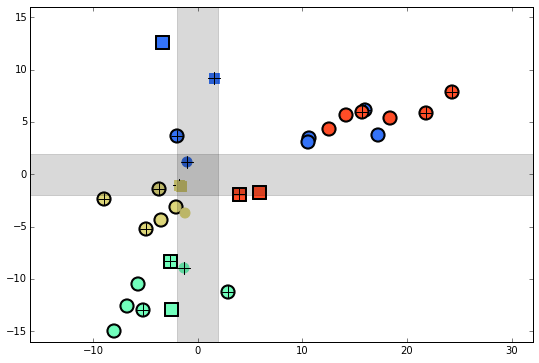

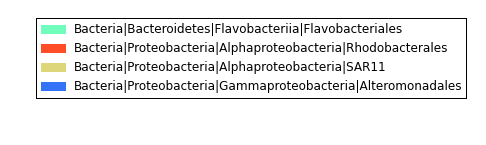

()

In [40]:
scatter_plot_assimilation(sample_list, taxa_z, sig_odr, colormap=cmap, markers=['s','s','o','o','o','o','o','o'],
                       vlines = [-1.96,1.96],hlines=[-1.96,1.96],w=9,h=6,
                       x_range=[-16,32],y_range=[-16,16],
                       plt1="",plt2="", colors=c)

### Plot low abundance taxa

In [47]:
ns_odr = ['Bacteria|Proteobacteria|Alphaproteobacteria|SAR116', 
         'Bacteria|Proteobacteria|Betaproteobacteria|Methylophilales', 
         'Bacteria|Cyanobacteria|Oscillatoriophycideae|Chroococcales', 
         'Bacteria|Proteobacteria|Gammaproteobacteria|SAR86', 
         'Bacteria|Proteobacteria|Gammaproteobacteria|SAR92', 
         'Bacteria|Proteobacteria|Gammaproteobacteria|OMG',
         'Bacteria|Proteobacteria|Gammaproteobacteria|Oceanospirillales']
ns_odr.sort()
c2 = [plt.get_cmap('spectral')(0.55), 
      plt.get_cmap('spectral')(0.82),
      plt.get_cmap('spectral')(0.7),
      plt.get_cmap('spectral')(0.37),
      plt.get_cmap('spectral')(0.27),
      plt.get_cmap('spectral')(0.19),
      plt.get_cmap('spectral')(0.07)]

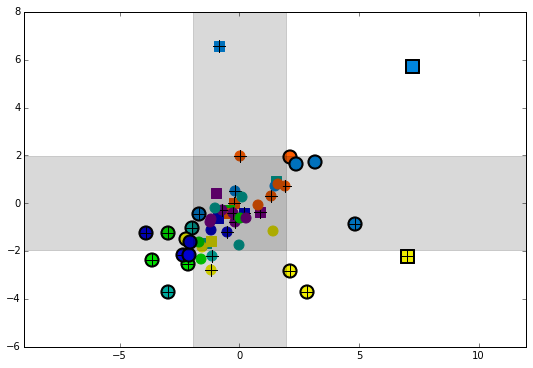

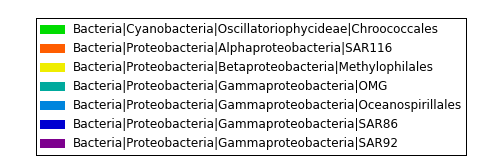

()

In [48]:
scatter_plot_assimilation(sample_list, taxa_z, ns_odr, colormap=cmap, markers=['s','s','o','o','o','o','o','o'],
                       vlines = [-1.96,1.96],hlines=[-1.96,1.96],w=9,h=6,
                      x_range=[-9,12],y_range=[-6,8],
                       plt1="",plt2="", colors=c2)

### Plot Rhodobacteriales - genera

In [43]:
rca_gen = [
 'Bacteria|Proteobacteria|Alphaproteobacteria|Rhodobacterales|Hyphomonadaceae|Robiginitomaculum',
 'Bacteria|Proteobacteria|Alphaproteobacteria|Rhodobacterales|Hyphomonadaceae|Unclassified_Hyphomonadaceae',
 'Bacteria|Proteobacteria|Alphaproteobacteria|Rhodobacterales|Rhodobacteraceae|Ahrensia',
 'Bacteria|Proteobacteria|Alphaproteobacteria|Rhodobacterales|Rhodobacteraceae|Dinoroseobacter',
 'Bacteria|Proteobacteria|Alphaproteobacteria|Rhodobacterales|Rhodobacteraceae|Loktanella',
 'Bacteria|Proteobacteria|Alphaproteobacteria|Rhodobacterales|Rhodobacteraceae|Oceanicola',
 'Bacteria|Proteobacteria|Alphaproteobacteria|Rhodobacterales|Rhodobacteraceae|Roseobacter',
 'Bacteria|Proteobacteria|Alphaproteobacteria|Rhodobacterales|Rhodobacteraceae|Roseovarius',
 'Bacteria|Proteobacteria|Alphaproteobacteria|Rhodobacterales|Rhodobacteraceae|Ruegeria',
 'Bacteria|Proteobacteria|Alphaproteobacteria|Rhodobacterales|Rhodobacteraceae|Sulfitobacter',
 'Bacteria|Proteobacteria|Alphaproteobacteria|Rhodobacterales|Rhodobacteraceae|Thalassobacter',
 'Bacteria|Proteobacteria|Alphaproteobacteria|Rhodobacterales|Rhodobacteraceae|Thalassobium',
 'Bacteria|Proteobacteria|Alphaproteobacteria|Rhodobacterales|Rhodobacteraceae|Unclassified_Rhodobacteraceae',
 'Bacteria|Proteobacteria|Alphaproteobacteria|Rhodobacterales|Unclassified_Rhodobacterales|Unclassified_Rhodobacterales']

In [45]:
rca_data, rca_z = taxa_enrichment_test (sample_list, "genus", rca_gen)

sample_name	sample_plsc	sample_enrv	taxa	taxa_plsc	plsc_Z	plsc_SIG	taxa_enrv	enrv_Z	enrv_SIG
OR2	    0.1034	    0.2076	Bacteria|Proteobacteria|Alphaproteobacteria|Rhodobacterales|Rhodobacteraceae|Dinoroseobacter	    0.3750	    2.4750	no	    0.2167	    0.4277	no

OR2	    0.1034	    0.2076	Bacteria|Proteobacteria|Alphaproteobacteria|Rhodobacterales|Rhodobacteraceae|Loktanella	    0.0498	   -0.9836	no	    0.1085	   -0.4968	no

OR2	    0.1034	    0.2076	Bacteria|Proteobacteria|Alphaproteobacteria|Rhodobacterales|Rhodobacteraceae|Oceanicola	    0.0000	   -0.6968	no	    0.0000	   -0.4153	no

OR2	    0.1034	    0.2076	Bacteria|Proteobacteria|Alphaproteobacteria|Rhodobacterales|Rhodobacteraceae|Roseobacter	    0.0751	   -1.3027	no	    0.1213	   -1.3563	no

OR2	    0.1034	    0.2076	Bacteria|Proteobacteria|Alphaproteobacteria|Rhodobacterales|Rhodobacteraceae|Ruegeria	    0.0915	   -0.2612	no	    0.1500	   -0.3030	no

OR2	    0.1034	    0.2076	Bacteria|Proteobacteria|Alphaproteobacteria|Rhodobac

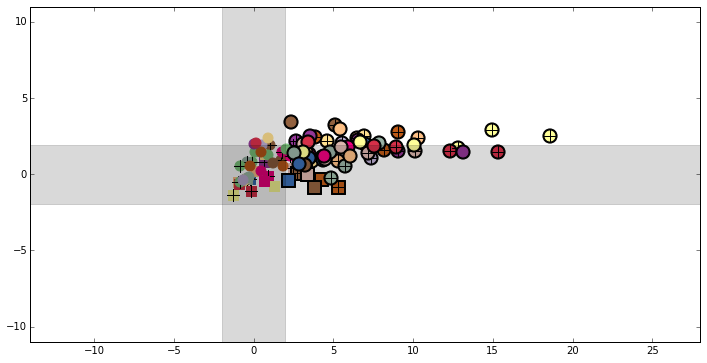

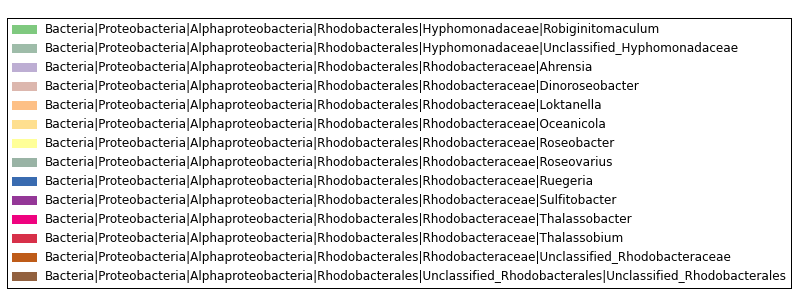

()

In [49]:
scatter_plot_assimilation(sample_list, rca_z, rca_gen, colormap='Accent', markers=['s','s','o','o','o','o','o','o'],
                       vlines = [-1.96,1.96],hlines=[-1.96,1.96],w=12,h=6,
                       x_range=[-14,28],y_range=[-11,11],
                       plt1="",plt2="", colors="")

### Plot Gammaproteobacteria - genera

In [50]:
gamma_gen = [
     'Bacteria|Proteobacteria|Gammaproteobacteria|Alteromonadales|Alteromonadaceae|Alteromonas',
     'Bacteria|Proteobacteria|Gammaproteobacteria|Alteromonadales|Alteromonadaceae|Glaciecola',
     'Bacteria|Proteobacteria|Gammaproteobacteria|Alteromonadales|Colwelliaceae|Colwellia',
     'Bacteria|Proteobacteria|Gammaproteobacteria|Alteromonadales|Idiomarinaceae|Idiomarina',
     'Bacteria|Proteobacteria|Gammaproteobacteria|Alteromonadales|Pseudoalteromonadaceae|Pseudoalteromonas',
     'Bacteria|Proteobacteria|Gammaproteobacteria|Alteromonadales|Psychromonadaceae|Psychromonas',
     'Bacteria|Proteobacteria|Gammaproteobacteria|Alteromonadales|Shewanellaceae|Shewanella',
     'Bacteria|Proteobacteria|Gammaproteobacteria|Alteromonadales|Unclassified_Alteromonadales|Unclassified_Alteromonadales']     
gamma_gen.sort()

In [51]:
gamma_data, gamma_z = taxa_enrichment_test (sample_list, "genus", gamma_gen)

sample_name	sample_plsc	sample_enrv	taxa	taxa_plsc	plsc_Z	plsc_SIG	taxa_enrv	enrv_Z	enrv_SIG
OR2	    0.1034	    0.2076	Bacteria|Proteobacteria|Gammaproteobacteria|Alteromonadales|Alteromonadaceae|Alteromonas	    0.1655	    1.7252	no	    0.4962	    2.5571	yes

OR2	    0.1034	    0.2076	Bacteria|Proteobacteria|Gammaproteobacteria|Alteromonadales|Alteromonadaceae|Glaciecola	    0.1434	    1.4430	no	    0.3487	    1.7300	no

OR2	    0.1034	    0.2076	Bacteria|Proteobacteria|Gammaproteobacteria|Alteromonadales|Colwelliaceae|Colwellia	    0.2066	    2.5493	yes	    0.8200	    4.4815	yes

OR2	    0.1034	    0.2076	Bacteria|Proteobacteria|Gammaproteobacteria|Alteromonadales|Idiomarinaceae|Idiomarina	    0.1113	    0.1121	no	    0.4773	    1.5160	no

OR2	    0.1034	    0.2076	Bacteria|Proteobacteria|Gammaproteobacteria|Alteromonadales|Pseudoalteromonadaceae|Pseudoalteromonas	    0.0756	   -0.7387	no	    0.8022	    4.5537	yes

OR2	    0.1034	    0.2076	Bacteria|Proteobacteria|Gammaproteobacteria|

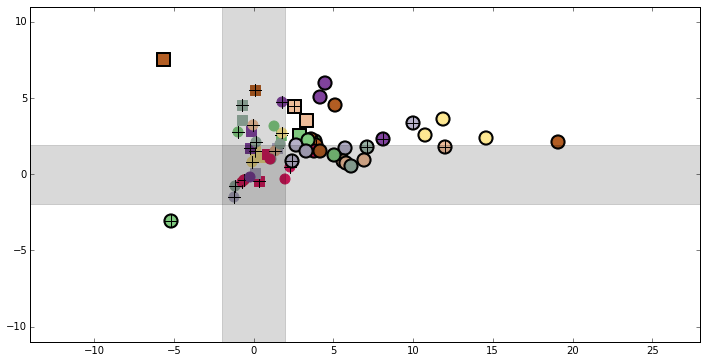

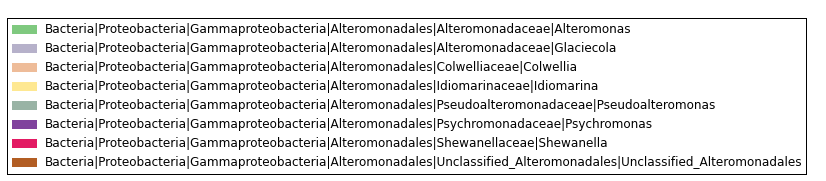

()

In [53]:
scatter_plot_assimilation(sample_list, gamma_z, gamma_gen, colormap='Accent', markers=['s','s','o','o','o','o','o','o'],
                       vlines = [-1.96,1.96],hlines=[-1.96,1.96],w=12,h=6,
                       x_range=[-14,28],y_range=[-11,11],
                       plt1="",plt2="", colors="")

### Plot Flavobacteriales - genera

In [54]:
flavo_gen = [
 'Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales|Cryomorphaceae|Owenweeksia',
 'Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales|Flavobacteriaceae|Aequorivita',
 'Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales|Flavobacteriaceae|Bizionia',
 'Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales|Flavobacteriaceae|Cellulophaga',
 'Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales|Flavobacteriaceae|Dokdonia',
 'Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales|Flavobacteriaceae|Flavobacterium',
 'Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales|Flavobacteriaceae|Formosa',
 'Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales|Flavobacteriaceae|Gramella',
 'Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales|Flavobacteriaceae|Joostella',
 'Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales|Flavobacteriaceae|Kordia',
 'Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales|Flavobacteriaceae|Lacinutrix',
 'Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales|Flavobacteriaceae|Leeuwenhoekiella',
 'Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales|Flavobacteriaceae|Maribacter',
 'Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales|Flavobacteriaceae|Mesoflavibacter',
 'Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales|Flavobacteriaceae|Muricauda',
 'Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales|Flavobacteriaceae|Polaribacter',
 'Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales|Flavobacteriaceae|Robiginitalea',
 'Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales|Flavobacteriaceae|Unclassified_Flavobacteriaceae',
 'Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales|Flavobacteriaceae|Winogradskyella',
 'Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales|Unclassified_Flavobacteriales|Unclassified_Flavobacteriales']


In [56]:
flavo_data, flavo_z = taxa_enrichment_test (sample_list, "genus", flavo_gen)

sample_name	sample_plsc	sample_enrv	taxa	taxa_plsc	plsc_Z	plsc_SIG	taxa_enrv	enrv_Z	enrv_SIG
OR2	    0.1034	    0.2076	Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales|Cryomorphaceae|Owenweeksia	    0.0691	   -2.0257	yes	    0.1069	   -2.0378	yes

OR2	    0.1034	    0.2076	Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales|Flavobacteriaceae|Aequorivita	    0.0360	   -1.7174	no	    0.0250	   -1.3178	no

OR2	    0.1034	    0.2076	Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales|Flavobacteriaceae|Cellulophaga	    0.1053	    0.0390	no	    0.0200	   -0.7103	no

OR2	    0.1034	    0.2076	Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales|Flavobacteriaceae|Dokdonia	    0.0000	   -0.7564	no	    0.0000	   -0.4146	no

OR2	    0.1034	    0.2076	Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales|Flavobacteriaceae|Flavobacterium	    0.1395	    2.4617	yes	    0.0301	   -3.9896	yes

OR2	    0.1034	    0.2076	Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales|Flavobacteriac

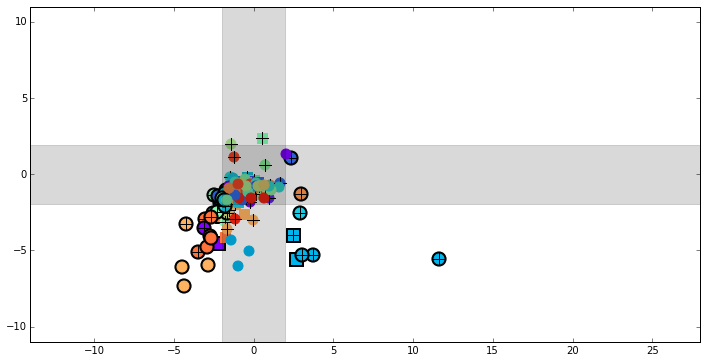

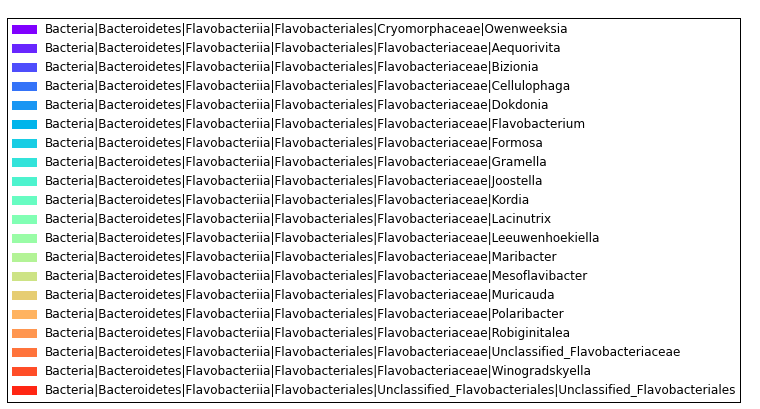

()

In [57]:
scatter_plot_assimilation(sample_list, flavo_z, flavo_gen, colormap='rainbow', markers=['s','s','o','o','o','o','o','o'],
                       vlines = [-1.96,1.96],hlines=[-1.96,1.96],w=12,h=6,
                       x_range=[-14,28],y_range=[-11,11],
                       plt1="",plt2="", colors="")

### Make heatmap of bactNOG enrichment for individual taxa

- A : RNA processing and modification
- B : Chromatin Structure and dynamics
- C : Energy production and conversion
- D : Cell cycle control and mitosis
- E : Amino acid transport and metabolism
- F : Nucleotide transport and metabolism
- G : Carbohydrate transport and metabolism
- H : Coenzyme transport and metabolism
- I : Lipid transport and metabolism
- J : Translation, ribosomal structure and biogenesis
- K : Transcription
- L : Replication, recombination and repair
- M : Cell wall/membrane/envelope biogenesis
- N : Cell Motility
- O : Posttranslational modification, protein turnover, chaperones
- P : Inorganic ion transport and metabolism
- Q : Secondary metabolites biosynthesis, transport and catabolism
- R : General function prediction only
- S : Function unknown
- T : Signal transduction mechanisms
- U : Intracellular trafficking, secretion, and vesicular transport
- V : Defense mechanisms
- W : Extracellular structures
- X : Unclassified
- Y : Nuclear structure
- Z : Cytoskeleton
- na : not assigned

In [58]:
cats = ['C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V']

In [59]:
def non_parametric_tests (value, distribution, percentile_kind = 'rank'):
    dist_mean = np.mean(distribution)
    dist_stdv = np.std(distribution)
    dist_medn = np.median(distribution)
    dist_vars = ""
    dist_sder = ""
    dist_95ci = ""
    value_z = (value - dist_mean)/dist_stdv
    percentile = stats.percentileofscore(distribution, value, kind=percentile_kind)
    p_low = len([x for x in distribution if x <= value])/float(len(distribution))
    p_high = len([x for x in distribution if x >= value])/float(len(distribution))
    return(dist_mean, dist_stdv, dist_medn, percentile, value_z, p_low, p_high)

In [72]:
def taxa_bactNOG_enrichment_test (sample_list, rank, taxa, cat_list, min_label=2):
    bactNOG_enrichment = {}
    for sample in sample_list:
        bactNOG_enrichment[sample.name] = {}
        if taxa in sample.summary[rank]:
            all_spec = []
            enrichments = sample.summary[rank][taxa]['enrichments']
            for i in range(len(enrichments)): #0 to 100
                for j in range(int(enrichments[i]+0.5)):
                    all_spec.append(i)
            for c in range(len(cat_list)):
                cat = cat_list[c]
                plsc = []
                plsSig = False
                cat_enrichments = sample.summary[rank][taxa]['bactNOG'][cat]['enrichments']
                cat_spec_count = sum(cat_enrichments)
                if cat_spec_count > 0:
                    cat_lsc = sum(cat_enrichments[min_label:])
                    cat_plsc = cat_lsc/cat_spec_count
                    subsample = int(cat_spec_count+0.5)
                    for m in range(1000):
                        test_spec = random.sample(all_spec, subsample)
                        test_labeled = [x for x in test_spec if x >= min_label]
                        if len(test_labeled) >= 1:
                            test_plsc = len(test_labeled)/float(subsample)
                        else:
                            test_plsc = 0.0
                        plsc.append(test_plsc)
                    plsA,plsS,plsM,plsPer,plsZ,plsPL,plsPH = non_parametric_tests(cat_plsc, plsc)
                    bactNOG_enrichment[sample.name][cat] = [plsZ, plsPer]
                    #plsL = np.percentile(plsc, 5, interpolation='midpoint')
                    #plsU = np.percentile(plsc, 95, interpolation='midpoint')
                    if plsPL <= 0.025 or plsPH <= 0.025:
                        plsSig = True
                    if plsSig==True:
                        print(sample.name+" | "+cat+" | "+str(plsPer)+" | "+str(plsZ))
                else:
                    bactNOG_enrichment[sample.name][cat] = [0.0, 50.0]
        else:
            for cc in cat_list:
                bactNOG_enrichment[sample.name][cat] = [0.0,50.0]
    return(bactNOG_enrichment)
                

In [73]:
def bi_cluster_heatmap (data_dict, row_list, column_list, colormap = "bwr", plot_name = "", cmin=-3.5, cmax=3.5, index=0):
    # make matrix for vertical clustering
    v_data_array = []
    for column in column_list:
        v_row = []
        for row in row_list:
            v_row.append(data_dict[row][column][index])
        v_data_array.append(v_row)
    v_data_array = np.asarray(v_data_array)
    v_distance_array = scipy.spatial.distance.pdist(v_data_array, 'euclidean')
    v_distance_array = scipy.spatial.distance.squareform(v_distance_array)
    v_linkage_array = scipy.cluster.hierarchy.average(v_distance_array)
    #make matrix for horizontal clustering
    h_data_array = []
    for row in row_list:
        h_row = []
        for column in column_list:
            h_row.append(data_dict[row][column][index])
        h_data_array.append(h_row)
    h_data_array = np.asarray(h_data_array)
    h_distance_array = scipy.spatial.distance.pdist(h_data_array, 'euclidean')
    h_distance_array = scipy.spatial.distance.squareform(h_distance_array)
    h_linkage_array = scipy.cluster.hierarchy.average(h_distance_array)
    # plot clusters
    fig = plt.figure(figsize=(8,3+len(row_list)/4),dpi=1000)
    gs = gridspec.GridSpec(3, 2,width_ratios=[3,7], height_ratios=[3,7,2], wspace=0.0, hspace=0.0) #
    ax1 = plt.subplot(gs[0,0]) #top-left --> empty
    ax2 = plt.subplot(gs[0,1]) #top-right --> vertical cluster
    ax3 = plt.subplot(gs[1,0]) #middle-left --> horizontal cluster
    ax4 = plt.subplot(gs[1,1]) #middle-right --> heatmap
    ax5 = plt.subplot(gs[2,0]) #bottom-left --> empty
    ax6 = plt.subplot(gs[2,1], sharex=ax4) # bottom-right --> heatmap colormap
    # empty spaces
    ax1.axis('off')
    ax5.axis('off')
    ax6.axis('off')
    # vertical dendrogram
    V = scipy.cluster.hierarchy.dendrogram(v_linkage_array, labels = column_list,no_labels=True, ax = ax2)
    v = V['leaves']
    columns = [column_list[i] for i in v]
    # horizontal dendrogram
    H = scipy.cluster.hierarchy.dendrogram(h_linkage_array, orientation='right', labels = row_list,no_labels=True, ax = ax3)
    h = H['leaves']
    rows = [row_list[i] for i in h]
    # make heatmap datta_array
    data_array = []
    for r in rows:
        row = []
        for c in columns:
            row.append(data_dict[r][c][0])
        data_array.append(row)
    data = np.asarray(data_array)
    ax4.pcolor(data, vmin=cmin, vmax=cmax, cmap=plt.get_cmap(colormap),edgecolors='k')
    ax4.set_xticks(np.arange(0,len(columns))+0.5)
    ax4.set_yticks(np.arange(0,len(data))+0.5)
    ax4.xaxis.tick_bottom()
    ax4.yaxis.tick_right()
    ax4.set_xticklabels(columns,minor=False,fontsize=8, rotation=45)
    ax4.set_yticklabels(rows,minor=False,fontsize=8)
    ax4.set_xlim(0,len(columns))
    ax4.set_ylim(0,len(rows))
    ax2.set_xticklabels([])
    ax3.set_yticklabels([])
    #fig.subplots_adjust(wspace=0)
    #fig.subplots_adjust(hspace=0.1)
    #add heatmap legend#
    bar = ax4.pcolormesh(data, vmin=cmin, vmax=cmax, cmap=plt.get_cmap(colormap))
    cbar = fig.colorbar(bar, ax=ax6, orientation='horizontal', fraction=0.5, pad=0.05)
    if plot_name:
        plt.savefig(plot_name)
    plt.show()

### Get bactNOG categories with significant label frequency for different orders
- Rhodobacterales
- Alteromonadales
- Pelagibacterales (SAR11)
- Flavobacteriales

In [74]:
rhodo_cats = taxa_bactNOG_enrichment_test (sample_list, 'order', 'Bacteria|Proteobacteria|Alphaproteobacteria|Rhodobacterales', cats, min_label=2)

OR2 | C | 2.4 | -1.85143627875
OR2 | E | 99.9 | 4.01032069281
OR2 | J | 0.0 | -3.63526378387
OR2 | K | 2.5 | -1.88233814114
OR2 | Q | 99.85 | 3.70779008493
OR1 | C | 0.6 | -2.20903560056
OR1 | E | 98.7 | 2.17770692271
MB2c | E | 99.7 | 2.92986738398
MB2c | G | 0.7 | -2.29258589185
MB2c | J | 0.0 | -2.93022788407
MB2c | K | 2.1 | -2.03108678707
MB2c | O | 99.6 | 2.6264614063
MB2c | S | 1.6 | -2.21026575632
MB2c | T | 100.0 | 5.18596702541
MB2b | G | 1.1 | -2.29743442244
MB2b | K | 0.1 | -2.73143858941
MB2b | Q | 99.6 | 2.58848072412
MB2b | R | 100.0 | 3.65149788367
MB2b | T | 100.0 | 4.26837703639
MB2a | E | 100.0 | 3.29227849916
MB2a | J | 1.0 | -2.28820290057
MB1c | E | 1.5 | -1.87439154952
MB1c | G | 0.0 | -3.37049593259
MB1c | J | 99.9 | 3.13527160105
MB1c | O | 100.0 | 4.52747427745
MB1c | S | 1.8 | -1.79098623922
MB1b | F | 99.2 | 3.33652056082
MB1b | G | 0.0 | -3.74789877196
MB1b | J | 99.7 | 2.97433945349
MB1b | O | 99.6 | 2.71886837252
MB1b | P | 0.7 | -2.11553914105
MB1a | G |

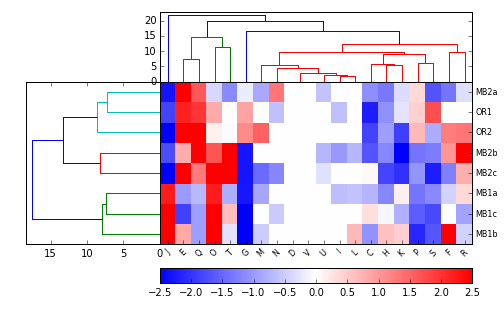

In [75]:
bi_cluster_heatmap (rhodo_cats, sample_names, cats, colormap = "bwr", plot_name = "", cmin=-2.5, cmax=2.5)

In [76]:
altero_cats = taxa_bactNOG_enrichment_test (sample_list, 'order', 'Bacteria|Proteobacteria|Gammaproteobacteria|Alteromonadales', cats, min_label=2)

OR2 | C | 100.0 | 4.0034100409
OR2 | E | 0.4 | -2.46462059362
OR2 | K | 1.0 | -2.05621143179
OR2 | Q | 99.4 | 3.1114494296
OR1 | C | 100.0 | 4.09427742416
OR1 | F | 2.1 | -1.67087197027
MB2c | J | 100.0 | 3.25911447467
MB2c | S | 0.1 | -2.75141931579
MB2b | J | 97.6 | 2.06266577148
MB2a | J | 100.0 | 3.51542124981
MB1c | J | 99.9 | 3.6120446775
MB1c | P | 0.2 | -3.15602888227
MB1b | J | 99.0 | 2.55461190664
MB1b | P | 0.2 | -2.83168386165
MB1a | J | 99.9 | 3.18793211271
MB1a | P | 0.6 | -2.53627829739


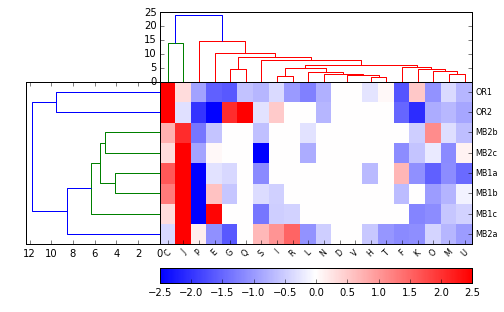

In [77]:
bi_cluster_heatmap (altero_cats, sample_names, cats, colormap = "bwr", plot_name = "", cmin=-2.5, cmax=2.5)

In [78]:
mb_list = [MB1a,MB1b,MB1c,MB2a,MB2b,MB2c]
mb_names = ['MB1a','MB1b','MB1c','MB2a','MB2b','MB2c']

In [79]:
pelagi_cats = taxa_bactNOG_enrichment_test (mb_list, 'order', 'Bacteria|Proteobacteria|Alphaproteobacteria|SAR11',
                                            cats, min_label=2)

MB1a | Q | 99.9 | 3.5171384063
MB1c | E | 0.9 | -2.19496367208
MB1c | O | 100.0 | 4.46661884765
MB1c | Q | 100.0 | 4.53376478921
MB2a | J | 1.6 | -1.93253448758
MB2a | O | 99.1 | 2.23176381935
MB2a | Q | 99.9 | 3.52465027093
MB2b | Q | 99.6 | 2.70409356553
MB2c | E | 1.4 | -2.18666302219
MB2c | K | 2.4 | -1.54663373783
MB2c | O | 100.0 | 10.3674116652


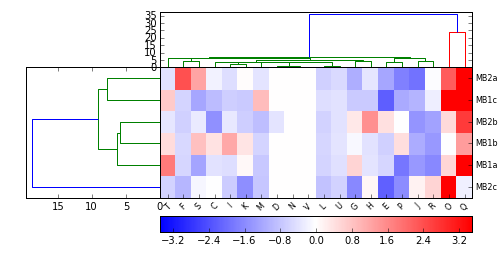

In [81]:
bi_cluster_heatmap (pelagi_cats, mb_names, cats, colormap = "bwr", plot_name = "", cmin=-3.5, cmax=3.5)

In [82]:
flavo_cats = taxa_bactNOG_enrichment_test (sample_list, 'order','Bacteria|Bacteroidetes|Flavobacteriia|Flavobacteriales', cats, min_label=2)

OR2 | I | 2.0 | -1.55189779265
OR2 | P | 99.6 | 2.63626056779
OR2 | S | 99.9 | 2.69880501161
OR1 | L | 98.0 | 2.14800353819
MB2c | E | 2.0 | -2.04836327312
MB2c | I | 0.2 | -2.36435255657
MB2c | J | 1.4 | -2.09594950883
MB2c | K | 0.9 | -2.22098460102
MB2c | O | 1.1 | -2.12395959559
MB2c | P | 100.0 | 5.64522072535
MB2c | S | 99.4 | 2.70510124549
MB2b | J | 0.3 | -2.86938457971
MB2b | L | 99.4 | 2.39444731511
MB2b | P | 100.0 | 6.51053607081
MB2a | J | 0.4 | -2.35026881314
MB2a | L | 1.4 | -1.69255497374
MB2a | P | 100.0 | 4.07397502881
MB2a | S | 99.2 | 2.87411447247
MB1c | F | 1.8 | -1.58760771916
MB1b | J | 99.8 | 2.95496533169
MB1b | L | 0.75 | -2.10706185477
MB1a | J | 99.9 | 3.11828615947


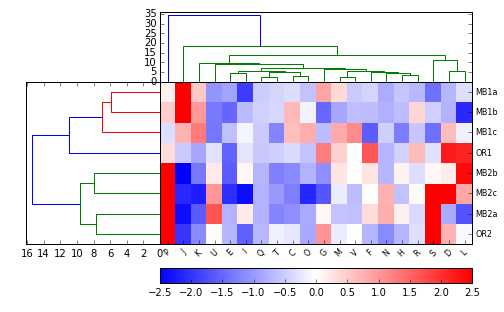

In [83]:
bi_cluster_heatmap (flavo_cats, sample_names, cats, colormap = "bwr", plot_name = "", cmin=-2.5, cmax=2.5)